# Identifying ghost hotels

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from pysal.lib import weights

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from numbers import Number

In [2]:
#Using a dataset with pre-normalised descriptions to reduce computational intensity
norm_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings-with-nlp-subset.csv.gz?raw=true',
                compression='gzip', dtype={'id':np.float64, 'name':str, 'listing_url':str, 'name':str, 'description':str, 'description_norm':str})

#Dataset with additional info
ref_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true',
                    compression='gzip', usecols=['id', 'room_type', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'host_id', 'host_name', 'availability_365', 'latitude', 'longitude', 'price', 'number_of_reviews_ltm', 'minimum_nights'],
                    dtype={'id':np.float64,
                           'room_type':str, 
                           'calculated_host_listings_count':np.float64,
                           'calculated_host_listings_count_entire_homes':np.float64,
                           'calculated_host_listings_count_private_rooms':np.float64,
                           'host_id':np.float64, 
                           'host_name':str, 
                           'availability_365':np.float64,
                           'latitude':np.float64,
                          'longitude':np.float64,
                          'price':str,
                          'number_of_reviews_ltm':np.float64,
                          'minimum_nights':np.float64})

In [3]:
df = pd.merge(norm_df, ref_df, on='id') #default is inner so we leave it
problematic_listings = df[(df.room_type == 'Hotel room') |
           (df.id.isna()) |
           (df.calculated_host_listings_count.isna()) |
           (df.latitude.isna())]
print(f'{(problematic_listings.shape[0]/df.shape[0])*100:.2f}% of listings cannot be used in the analysis, and will be dropped')
df.drop(problematic_listings.index, inplace=True)

#Converting columns
df['price'] = df['price'].str.replace('$','').str.replace(',','').astype('float')
ints = ['id', 'host_id', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'availability_365', 'number_of_reviews_ltm', 'minimum_nights']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype(pd.UInt16Dtype())

#Setting custom index
df.set_index('id', inplace=True)

0.78% of listings cannot be used in the analysis, and will be dropped
Converting id
Converting host_id
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting calculated_host_listings_count_private_rooms
Converting availability_365
Converting number_of_reviews_ltm
Converting minimum_nights


In [4]:
#Dropping listings with abnormally high prices for their room type
eh_cutoff = df[
    df['room_type'] == 'Entire home/apt'
].price.quantile(.99)

prv_cutoff = df[
    df['room_type'] == 'Private room'
].price.quantile(.99)

abnormal_prices = df[
    ((df['room_type'] == 'Entire home/apt') & (df['price'] >= eh_cutoff)) |
    ((df['room_type'] == 'Private room') & (df['price'] >= prv_cutoff))
]

print(f'{abnormal_prices.shape[0]} listings had abnormally high prices that may skew the revenue analysis, and will be dropped')
df.drop(abnormal_prices.index, inplace=True)

748 listings had abnormally high prices that may skew the revenue analysis, and will be dropped


In [5]:
#Finding revenue from revenue-generating listings
def get_revenue(minimum_nights:int, number_of_reviews_ltm:int, price:float) -> float:
    s = 5.3 #average stay in London, based on GLA report
    if minimum_nights > s: #hosts can set a minimum nights stay of longer than 5.3 nights
        s = minimum_nights
    b = 2 * number_of_reviews_ltm #assumes that 50% of bookings result in reviews, based on Inside Airbnb model
    occupancy = s*b #estimates number of nights property was occupied
    if occupancy > 255: #building on GLA report, occupancy is capped at 255 nights
        occupancy = 255
    p = price 
    rev = occupancy * p #revenue is multiplied by the nightly price and number of nights occupied
    return rev

df['revenue'] = df.apply(lambda x: get_revenue(x.minimum_nights, x.number_of_reviews_ltm, x.price), axis=1)

In [6]:
#Dropping non-revenue generating listings and listings with abnormal prices, which indicate lack of availability or typos
non_revenue = df[df['revenue'] == 0]

print(f'{(non_revenue.shape[0]/df.shape[0])*100:.2f}% of listings did not generate revenue in the past year, and will be dropped')

df.drop(non_revenue.index, inplace=True)
print(f'{df.shape[0]} listings will be used in the analysis')

54.17% of listings did not generate revenue in the past year, and will be dropped
33390 listings will be used in the analysis


## Ghost hotel extraction

In [7]:
def ghost_hotels(df:pd.DataFrame, room_type:str) -> pd.DataFrame:
    '''This function isolates potential ghost listings and performs textual + spatial cluster analysis.
    Use the original listings df as the input, and assign the output of this function to a new df,
    which will contain ghost listings with their ghost hotel IDs.
    Change the room_type depending on whether you want to analyse entire-home ghost hotels or private-room ghost hotels.'''
    if room_type == 'Entire home/apt':
        potential_ghosts = df[(df['calculated_host_listings_count_entire_homes'] >= 2) &
                       (df['room_type'] == room_type) &
                       (~df['description_norm'].isna())].copy()
    elif room_type == 'Private room':
        potential_ghosts = df[(df['calculated_host_listings_count_private_rooms'] > 2) &
                             (df['room_type'] == room_type) &
                             (~df['description_norm'].isna())].copy()
    print(f'There are {potential_ghosts.shape[0]} candidates for {room_type} ghost listings.')
    
    print('Running textual similarity analysis...')
    corpus = potential_ghosts.description_norm.values
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), max_df=0.5, min_df=0.05)
    #ignore terms that appear in over 50% or less than 5% of documents to save memory
    tcorpus = vectorizer.fit_transform(corpus).toarray() 
    #fit creates list of words/ngrams + IDF scores
    #transform creates matrix of TF/IDF scores per word/ngram
    #convert to array for cosine similarity step
    
    #Cosine distance analysis
    keys = potential_ghosts.index #allows cosine distance calculator output to be indexed by listing ID, which makes analysis easier
    cosine_distances = pd.DataFrame(squareform(pdist(tcorpus, metric='cosine')), index=keys, columns=keys)
    
    #Filtering down to listings that meet criteria for textual similarity with multiple listings
    ghost_listings = cosine_distances[(cosine_distances < 0.2).sum(1) > 2].index.tolist()
    ghost_listings_mat = cosine_distances.loc[ghost_listings, ghost_listings]
    print(f'{ghost_listings_mat.shape[0]} listings had more than 1 textually similar listing, and will be used in the text clustering process.')
    
    #Set up data frame to store clustering results, which has all the columns in the original df
    results = potential_ghosts.loc[ghost_listings,]
    
    #Function for implementing both textual and spatial cluster analysis
    def db_cluster(df1, df2, eps:Number, metric:str, name:str):
        '''Implements DBSCAN clustering algorithm on df1 and stores results in df2'''
        print(f'Running {name} analysis...')
        output = DBSCAN(eps=eps, min_samples=3, metric=metric).fit(df1)
        s = pd.Series(output.labels_, index=df2.index, name=name) #create series assigning listings to clusters
        df2[name] = s #assign series to results df     
        noise = df2[df2[name] == -1] #identify listings that weren't in clusters
        print(f'Dropping {noise.shape[0]} listings that do not belong to a cluster')
        df2.drop(noise.index, inplace=True)
        return df2 #returns filtered df, with only listings that are in clusters
    
    #Textual DBSCAN
    results = db_cluster(ghost_listings_mat, results, 0.2, 'precomputed', 'text_dbscan')
    
    #Spatial DBSCAN
    spatial_dbs_listings = results[['latitude', 'longitude']] #isolate latitude/longitude pairs
    spatial_dbs_listings = spatial_dbs_listings.apply(np.radians) #convert coordinates to radians for use in DBSCAN clustering
    
    e = 0.3/6371.0088 #divide maximum distance (in km) between two listings that could be in the same building by km per radian
    results = db_cluster(spatial_dbs_listings, results, e, 'haversine', 'geo_dbscan')
    
    #Identify potential hotels by grouping results df by combination of clusters
    #We assume that potential hotels are in the same spatial and textual clusters
    hotels = results.groupby(['geo_dbscan','text_dbscan']).size().reset_index().rename(columns={0:'count'})
    print(f'There are {hotels.shape[0]} potential {room_type} ghost hotels in London.')
    
    #Match hotels to listings
    hotels['hotel_id'] = hotels.index.values   
    results['id'] = results.index.values #the merge can reset the index, which we don't want
    final_results = results.merge(hotels, how='left').set_index('id')
    print(f'{final_results.shape[0]} {room_type} listings are in potential ghost hotels, which account for {(final_results.shape[0]/df.shape[0])*100:.2f}% of revenue-generating listings')
    
    #Free up memory so this function can be run on other listing datasets or another room type
    del(tcorpus)
    del(cosine_distances)
    
    return final_results

In [8]:
entire_home_ghosts = ghost_hotels(df, 'Entire home/apt')

There are 9319 candidates for Entire home/apt ghost listings.
Running textual similarity analysis...
2664 listings had more than 1 textually similar listing, and will be used in the text clustering process.
Running text_dbscan analysis...
Dropping 35 listings that do not belong to a cluster
Running geo_dbscan analysis...
Dropping 98 listings that do not belong to a cluster
There are 495 potential Entire home/apt ghost hotels in London.
2531 Entire home/apt listings are in potential ghost hotels, which account for 7.58% of revenue-generating listings


Before the analysis, we have to exclude listings from Sonder, a serviced apartment company that is licensed to run as a hotel. This clustering analysis identified Sonder's listings as potential ghost hotels. 

In [9]:
entire_home_ghosts.drop(entire_home_ghosts[
    entire_home_ghosts['host_name'].str.contains('Sonder')
].index, inplace=True)

print(f'{entire_home_ghosts.shape[0]} listings are in suspected ghost hotels.')

2384 listings are in suspected ghost hotels.


In [10]:
private_room_ghosts = ghost_hotels(df, 'Private room')

There are 3645 candidates for Private room ghost listings.
Running textual similarity analysis...
1532 listings had more than 1 textually similar listing, and will be used in the text clustering process.
Running text_dbscan analysis...
Dropping 23 listings that do not belong to a cluster
Running geo_dbscan analysis...
Dropping 29 listings that do not belong to a cluster
There are 331 potential Private room ghost hotels in London.
1480 Private room listings are in potential ghost hotels, which account for 4.43% of revenue-generating listings


## Revenue analysis

### How much of the total revenue from Airbnb in London was generated by ghost hotels between 2019 and 2020?

In [ ]:
def revenue_analysis(df1, df2):
    '''This function analyses ghost-hotel listings' share of listings and revenue compared to entire-home listings
    and Airbnb listings in total.
    df1 is the full df of revenue-generating listings, and df2 is the df of suspected ghost-hotel listings.'''
    
    df1['is_ghost_listing'] = df1.index.isin(df2.index.values) #produce boolean series indicating whether or not a listing is a ghost-hotel listing
    entire_homes = df1[df1['room_type'] == 'Entire home/apt'] #isolate entire home listings
    
    def get_stat_table(df, name):
        '''This helper function produces the table used for the revenue analysis.
        name = df1 name if comparing to all listings, entire_homes if comp'''
    

In [11]:
ghost_listings_total = entire_home_ghosts.index.values.tolist() + private_room_ghosts.index.values.tolist()
df['is_ghost_listing'] = df.index.isin(ghost_listings_total)

In [12]:
#Necessary information:
# - % of listings
# - % of revenue
ghost_vs_total = df.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'median']})
ghost_vs_total.columns = ghost_vs_total.columns.droplevel(0)

In [13]:
ghost_vs_total

,count,sum,median
is_ghost_listing,,,
False,29526,1.917851e+08,3498.000
True,3864,2.820418e+07,4539.474


In [14]:
print(f"""Ghost hotel listings make up {(ghost_vs_total['count'].values[1]/df.shape[0])*100:.2f}% of Airbnb listings in London,
and accounted for {(ghost_vs_total['sum'].values[1]/df['revenue'].sum())*100:.2f}% of total revenue produced from August 2019 to August 2020.""")

Ghost hotel listings make up 11.57% of Airbnb listings in London,
and accounted for 12.82% of total revenue produced from August 2019 to August 2020.


### How much of the revenue from entire-home listings was generated by ghost hotels between 2019 and 2020?

In [15]:
entire_homes = df[df['room_type'] == 'Entire home/apt']

In [16]:
ghost_vs_entirehomes = entire_homes.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'mean', 'min', 'max', 'median']})
ghost_vs_entirehomes.columns = ghost_vs_entirehomes.columns.droplevel(0)

In [17]:
ghost_vs_entirehomes

,count,sum,mean,min,max,median
is_ghost_listing,,,,,,
False,17300,1.437185e+08,8307.425556,212.0,175695.0,4664.0
True,2384,2.025501e+07,8496.229589,148.4,81916.8,5278.8


In [18]:
prop_entirehome_list = (ghost_vs_entirehomes['count'].values[1]/entire_homes.shape[0])*100
prop_entirehome_rev = (ghost_vs_entirehomes['sum'].values[1]/entire_homes['revenue'].sum())*100

print(f'Ghost hotels make up {prop_entirehome_list:.2f}% of entire home listings in London, and accounted for {prop_entirehome_rev:.2f}% of revenue generated from August 2019-2020.')

Ghost hotels make up 12.11% of entire home listings in London, and accounted for 12.35% of revenue generated from August 2019-2020.


### How much of the revenue from private-room listings was generated by ghost hotels between 2019 and 2020?

In [19]:
private_rooms = df[df['room_type'] == 'Private room']
ghost_vs_private_rooms = private_rooms.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'median']})

In [20]:
ghost_vs_private_rooms.columns = ghost_vs_private_rooms.columns.droplevel(0)

In [21]:
ghost_vs_private_rooms

,count,sum,median
is_ghost_listing,,,
False,12044,4.769425e+07,2120.0
True,1480,7.949168e+06,3498.0


In [43]:
prop_prv_list = (ghost_vs_private_rooms['count'].values[1]/private_rooms.shape[0])*100
prop_prv_rev = (ghost_vs_private_rooms['sum'].values[1]/private_rooms['revenue'].sum())*100

print(f'Ghost hotels make up {prop_prv_list:.2f}% of private-room listings in London, and accounted for {prop_prv_rev:.2f}% of revenue in 2019-2020.')

Ghost hotels make up 11.13% of private-room listings in London, and accounted for 15.44% of revenue in 2019-2020.


## The spatial bits!

In [44]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
gdf = gdf.to_crs(boros.crs) #reproject so that we can map it later

### Mapping ghost hotels

In [48]:
geo_ghost_prv = pd.merge(private_room_ghosts, gdf, how='left', left_index=True, right_index=True)[['geometry', 'hotel_id', 'count']]
geo_ghost_eh = pd.merge(entire_home_ghosts, gdf, how='left', left_index=True, right_index=True)[['geometry', 'hotel_id', 'count']]

<AxesSubplot:>

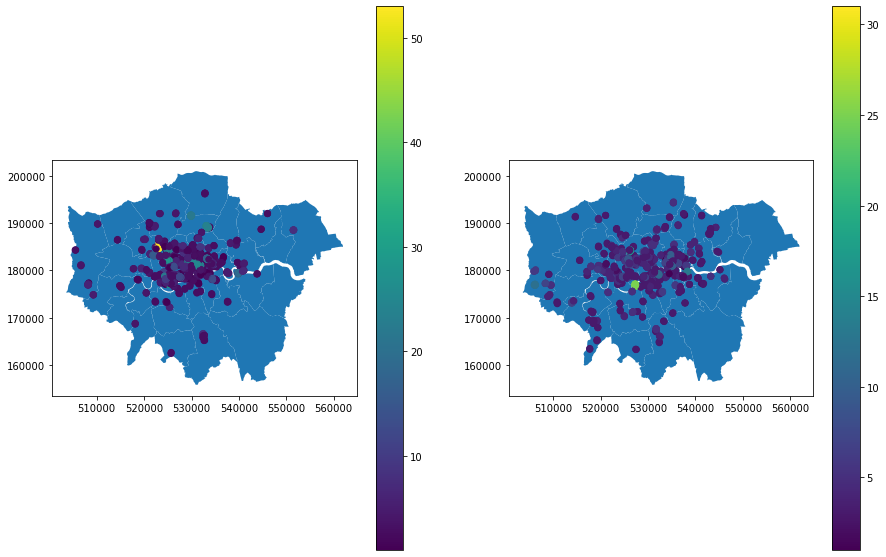

In [63]:
geo_ghost_eh = gpd.GeoDataFrame(geo_ghost_eh, geometry='geometry', crs='epsg:27700')
geo_ghost_prv = gpd.GeoDataFrame(geo_ghost_prv, geometry='geometry', crs='epsg:27700') #a for loop didn't work for this for some reason

fig, axes = plt.subplots(1,2, figsize=(15,10))
boros.plot(ax=axes[0])
boros.plot(ax=axes[1])
geo_ghost_eh.plot(ax=axes[0], column='count', legend=True)
geo_ghost_prv.plot(ax=axes[1], column='count', legend=True)

<AxesSubplot:ylabel='Frequency'>

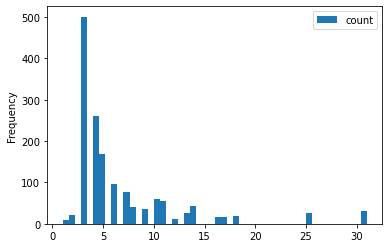

In [57]:
geo_ghost_prv[['count']].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

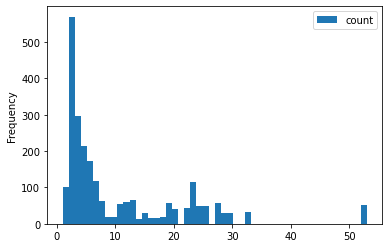

In [69]:
geo_ghost_eh[['count']].plot.hist(bins=50)

### Mapping percentage of listings in each borough that are ghost hotels

In [58]:
#Get LSOAs and extract LSOAs that are in London
lsoas = gpd.read_file('https://github.com/caranvr/i2p-assessment/blob/main/Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2-shp.zip?raw=true')

#Dissolve borough boundaries by London boundary
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')

ldn_lsoas = gpd.sjoin(lsoas, ldn, op='within')
del(lsoas)

In [ ]:
#Extract boroughs
ldn_lsoas['Borough'] = ldn_lsoas.LSOA11NM.str.replace(r'\s\d{3}\w+$','',regex=True)

print(ldn_lsoas.Borough.unique())
print(len(ldn_lsoas.Borough.unique()))
print(ldn_lsoas.shape)

In [ ]:
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

In [ ]:
#Drop listings that fall on the border between boroughs - there are only 5
gdf_la.drop(index=gdf_la[gdf_la.NAME.isnull()].index.values, axis=1, inplace=True) #5
print(gdf_la.shape)

In [ ]:
gdf_la.groupby('NAME').is_ghost_listing.apply(lambda x: (x.sum()/x.count())*100).plot.hist(bins=)

### Mapping percentage of ghost-hotel listings in each LSOA

In [59]:
ldn_lsoas.drop(columns='index_right', inplace=True)
listings_with_lsoas = gpd.sjoin(
            gdf, 
            ldn_lsoas, 
            op='within')

In [ ]:
listings_with_lsoas.columns

In [ ]:
lsoa_ghost_pc = listings_with_lsoas.groupby('LSOA11CD').is_ghost_listing.apply(lambda x: (x.sum()/x.count())*100)

In [ ]:
lsoa_ghost_pc.head()

In [ ]:
ldn_lsoas.set_index('LSOA11CD', inplace=True)

In [ ]:
ldn_lsoas = pd.concat([ldn_lsoas, lsoa_ghost_pc], axis=1)

In [ ]:
ldn_lsoas.columns

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ldn_lsoas.plot(column='is_ghost_listing', ax=ax, legend=True)

In [ ]:
ldn_lsoas[
    ldn_lsoas['is_ghost_listing'] == ldn_lsoas['is_ghost_listing'].max()
]

### Mapping % of properties in each LSOA that are ghost listings

In [ ]:
lsoa_properties = pd.read_csv('https://github.com/caranvr/i2p-assessment/blob/main/Table_CTSOP4_1_2020.csv?raw=true')

# Executive Briefing

## Background

Since 2015, short-term letting of entire homes in London has been limited to 90 nights per year, a move to protect residential housing supply from the growing home-sharing market (Cosh, 2020). Airbnb has enforced this rule since 2017, automatically suspending bookings for entire-home listings that been booked for 90 days in a year (KeyNest, 2019). However, recent media and policy investigations have identified a new way for commercial short-term rental (STR) operators to skirt this regulation: the operation of 'ghost hotels', which are clusters of unlicensed STRs in the same building. 

Ghost hotels can take two different forms, which take advantage of different loopholes in London's STR limit. The first type of ghost hotel is the **entire-home ghost hotel**. These ghost hotels consist of multiple flats in the same building, each of which are either listed on home-sharing platforms at different times of the year, or listed multiple times with mirrored photos to avoid detection. This ensures that while no individual flat is let – or recorded as having been let – for more than 90 days per year, operators can profit from listings year-round. A recent _Wired_ investigation found that some of London's entire-home ghost hotels operate at a similar scale to traditional hotels: a ghost hotel block in Battersea, which has since been removed from Airbnb, consisted of at least twenty flats (Temperton, 2020). 

The second type of ghost hotel is the **private-room ghost hotel**, which was first identified in New York City by urban policy researchers at McGill University (Wachsmuth _et al._, 2018). These ghost hotels encompass one or more apartments in a building, with each room listed separately on Airbnb. In London, private-room ghost hotels take advantage of the fact that only entire-home listings are monitored on Airbnb (KeyNest, 2019). 

### Impact of ghost hotels

While spatially dispersed commercial Airbnb listings may violate London's short-term letting laws in similar ways, the density of STRs in ghost hotels poses a unique threat to local residents' quality of life. In Lisbon and Amsterdam, residents of neighbourhoods with high concentrations of STRs have complained of overcrowding; construction noise from conversions of flats to STRs; the replacement of local shops and restaurants with tourist-oriented businesses; and disintegration of community relations as long-term residents are replaced by travelers (Pinkster and Boterman, 2017; Cocola-Gant and Gago, 2018). 

### Aims of this report

- Evaluate which form of ghost hotel is a larger threat to local quality of life in London
    - Analyse position of each type of ghost hotel in the local Airbnb market (each type analysed separately)
    - Analyse the spatial distribution of ghost-hotel listings (combined)
    - 

## Ghost hotels are a small but lucrative portion of London's Airbnb market
Necessary information:
- Extent of ghost hotel listings is slightly lower than in New York City
    - Both types of ghost hotels combined composed 11.67% of London's active listings in August 2020
    - Separately, entire-home and private-room ghost hotel listings composed similar proportions of listings with their respective room types
- However, both private-room and entire-home ghost hotel listings earned more on average than other listings of their respective room types
    - Especially pronounced for private-room listings: the median revenue for private-room listings in ghost hotels was 67% higher than for other private-room listings
    - **Create grouped box plot of revenue**

## Ghost hotels are concentrated in areas with low overall Airbnb density

Necessary information:
- Both types of ghost hotels are considered together in this analysis, as they have similar impacts on local quality of life
- **Map of ghost hotels, colored according to the number of listings associated with the ghost hotel**

## Ghost hotels are associated with new-build developments

In [22]:
private_room_ghosts.groupby('hotel_id').revenue.sum().sort_values(ascending=False)[0:10]

hotel_id
281    292307.40
238    250658.25
90     182440.60
180    163116.06
92     160454.67
265    148230.40
98     143345.70
276    140598.45
128    121856.80
224    121847.60
Name: revenue, dtype: float64

In [26]:
private_room_ghosts[
    private_room_ghosts['hotel_id'] == 90
]

,listing_url,name,description,description_norm,host_id,host_name,latitude,longitude,room_type,price,...,availability_365,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,revenue,text_dbscan,geo_dbscan,count,hotel_id
id,,,,,,,,,,,,,,,,,,,,,
21175319,https://www.airbnb.com/rooms/21175319,C-3) Massive Room in Prime Location,This 4 bedroom VINTAGE House near Mornington ...,bedroom vintage house near mornington crescent...,136482864,Hasan,51.53517,-0.13763,Private room,84.0,...,0,19,15,1,14,16917.6,113,24,11,90
26763103,https://www.airbnb.com/rooms/26763103,London House 1,This 4 bedroom VINTAGE House near Mornington ...,bedroom vintage house near mornington crescent...,201244309,Ali,51.53593,-0.13590,Private room,74.0,...,36,31,27,2,25,18870.0,113,24,11,90
36446046,https://www.airbnb.com/rooms/36446046,3)Budget Friendly Room in Camden Town.,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,201244309,Ali,51.53910,-0.13844,Private room,45.0,...,0,21,27,2,25,10017.0,113,24,11,90
36448123,https://www.airbnb.com/rooms/36448123,4) Double Room in Camden,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,201244309,Ali,51.53751,-0.13887,Private room,51.0,...,0,19,27,2,25,10271.4,113,24,11,90
36448329,https://www.airbnb.com/rooms/36448329,1) Private Room in Camden for 4 People.,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,201244309,Ali,51.53825,-0.13893,Private room,55.0,...,0,16,27,2,25,9328.0,113,24,11,90
36719596,https://www.airbnb.com/rooms/36719596,London House 4,This 4 bedroom VINTAGE House near Mornington ...,bedroom vintage house near mornington crescent...,201244309,Ali,51.53403,-0.13649,Private room,45.0,...,0,28,27,2,25,11475.0,113,24,11,90
38750966,https://www.airbnb.com/rooms/38750966,T1)Budget Friendly Small Room in Camden Town,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,136482864,Hasan,51.53622,-0.13660,Private room,100.0,...,180,36,15,1,14,25500.0,113,24,11,90
38751181,https://www.airbnb.com/rooms/38751181,T2)Double Room in Camden with Spacious Patio,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,136482864,Hasan,51.53707,-0.13825,Private room,100.0,...,365,44,15,1,14,25500.0,113,24,11,90
38751304,https://www.airbnb.com/rooms/38751304,T3)Spacious Room for 3 in Camden,4 Bedroom Flat in Camden Town. This listing is...,bedroom flat camden town listing one room hous...,136482864,Hasan,51.53759,-0.13781,Private room,100.0,...,365,30,15,1,14,25500.0,113,24,11,90


In [27]:
entire_home_ghosts.groupby('hotel_id').revenue.sum().sort_values(ascending=False)[0:10]

hotel_id
14     489645.800
222    468690.000
198    404394.300
148    309547.206
46     296189.400
83     253143.000
200    210490.000
332    199229.000
9      194255.874
423    180549.800
Name: revenue, dtype: float64

In [32]:
entire_home_ghosts[
    entire_home_ghosts['hotel_id'] == 46
]

,listing_url,name,description,description_norm,host_id,host_name,latitude,longitude,room_type,price,...,availability_365,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,revenue,text_dbscan,geo_dbscan,count,hotel_id
id,,,,,,,,,,,,,,,,,,,,,
23497042,https://www.airbnb.com/rooms/23497042,NEXT to BritishMuseum - Large Apartment for 5 ppl,This cozy and super central two-bedroom apartm...,cozy super central two bedroom apartment sleep...,175413710,Bedford Place Apartments,51.52140,-0.12486,Entire home/apt,247.0,...,0,32,11,11,0,62985.0,165,1,11,46
26119027,https://www.airbnb.com/rooms/26119027,NEXT to BritishMuseum - Large Apartment for 3 ppl,This cozy and super central one-bedroom apartm...,cozy super central one bedroom apartment sleep...,175413710,Bedford Place Apartments,51.51961,-0.12513,Entire home/apt,184.0,...,365,32,11,11,0,46920.0,165,1,11,46
26119157,https://www.airbnb.com/rooms/26119157,NEXT to BritishMuseum - 4 bedroom sleeping 10 ppl,This beautiful duplex unit is composed of two ...,beautiful duplex unit compose two interconnect...,175413710,Bedford Place Apartments,51.51999,-0.12419,Entire home/apt,513.0,...,79,4,11,11,0,21751.2,165,1,11,46
26119197,https://www.airbnb.com/rooms/26119197,NEXT to BritishMuseum -2 bedroom sleeping 4 ppl,This cozy and super central two-bedroom apartm...,cozy super central two bedroom apartment sleep...,175413710,Bedford Place Apartments,51.52136,-0.12580,Entire home/apt,221.0,...,365,7,11,11,0,16398.2,165,1,11,46
26119247,https://www.airbnb.com/rooms/26119247,NEXT to BritishMuseum - Large Apartment for 6 ppl,This cozy and super central two-bedroom apartm...,cozy super central two bedroom apartment sleep...,175413710,Bedford Place Apartments,51.52112,-0.12402,Entire home/apt,278.0,...,176,7,11,11,0,20627.6,165,1,11,46
26119299,https://www.airbnb.com/rooms/26119299,NEXT to BritishMuseum - 3Bed Apartment for 8 ppl,This cozy and super central three-bedroom apar...,cozy super central three bedroom apartment sle...,175413710,Bedford Place Apartments,51.52108,-0.12423,Entire home/apt,368.0,...,79,21,11,11,0,81916.8,165,1,11,46
26407624,https://www.airbnb.com/rooms/26407624,5 Bedroom flat sleeping 8 - near British Museum,This cozy and super central five-bedroom apart...,cozy super central five bedroom apartment slee...,198568388,Byng Place,51.52394,-0.13116,Entire home/apt,401.0,...,78,2,12,12,0,8501.2,165,1,11,46
39045711,https://www.airbnb.com/rooms/39045711,Cozy and Central 2 Bedroom for 4 (refurbished),"This cozy and super central, recently refurbis...",cozy super central recently refurbish two bedr...,175413710,Bedford Place Apartments,51.52181,-0.12391,Entire home/apt,237.0,...,173,3,11,11,0,7536.6,165,1,11,46
39047338,https://www.airbnb.com/rooms/39047338,Cozy and Central 2 Bedroom for 5 (refurbished),"This cozy and super central, recently refurbis...",cozy super central recently refurbish two bedr...,175413710,Bedford Place Apartments,51.52114,-0.12554,Entire home/apt,264.0,...,176,2,11,11,0,5596.8,165,1,11,46
